In [1]:
import gym
import matplotlib.pyplot as plt
import random
import numpy as np
from gridworld.gridworld import GridWorldEnvNew

import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

env = gym.make('MyGridworld-v2')
store_state = {}
store_action = {}
store_reward = {}
store_qfunc = {}
total_reward = []

a_seed = 543
a_render = True 
a_gamma = 1
a_log_interval = 10
a_lr = 1e-2

env.seed(a_seed)
torch.manual_seed(a_seed)

In [2]:
def compute_gradient(state, action, policy):
    
    delt_grad = np.zeros(policy.shape)
    
    ### softmax layer 
    pmf_smax = np.exp(policy[state,:]) / np.sum(np.exp(policy[state,:]), axis=0)

    ### Finding Delta_grad-> \delta_{ss} and \delta_{aa}
    delt_grad[state,:] = -pmf_smax[action]
    delt_grad[state,action] = 1 - pmf_smax[action]
    
    return delt_grad

In [3]:
def REINFORCE_learning(no_episodes, episode_len,batch_size, alpha): 
    no_batch = int(no_episodes/batch_size)
    pfunc = np.zeros([env.observation_space.n, env.action_space.n])
    rf_reward = []

    for i_batch in range(no_batch): 
        delt_grad = np.zeros(pfunc.shape)
        reward_batch = 0
    
        for n in range(batch_size):
            ### Initialize the episode with random state
            init_state, cur_pos = env.reset()
            #print('Reset state: ', init_state)
    
            store_s = np.zeros([episode_len], dtype=int)
            store_a = np.zeros([episode_len], dtype=int)
            store_r = np.zeros([episode_len], dtype=int)   
            for t in range(episode_len):        
        
                ### policy based action gradient
                pmf_smax = np.exp(pfunc[cur_pos,:]) / np.sum(np.exp(pfunc[cur_pos,:]), axis=0)
                a = np.random.choice(np.arange(pfunc.shape[1]), 1, replace=False, p=pmf_smax)
                action =  int(a) 
                store_a[t] = action
        
                ### Environment is propagated based on action taken
                next_state, reward, done, info = env.step(action)
                next_pos = info['pos'] ## S'
        
                ### Plotting and Storing
                #print(" ")
                #print("Action: ", action)     
                #print("Reward: ", reward)
                #print("State:  ", next_pos, next_state)
                store_s[t] = next_pos
                store_r[t] = reward
            
                cur_pos = next_pos ## S<--S
                env.render()
    
            #### Here update the policy based on the episode states, actions and rewards
            grad_eps = np.zeros(pfunc.shape)
            reward_eps = 0
            for t in range(episode_len):
                #update the gradient
                grad_eps += compute_gradient(store_s[t], store_a[t], pfunc)
                reward_eps += store_r[t]

            delt_grad += (grad_eps * reward_eps) / batch_size
            reward_batch += reward_eps / batch_size
        
        #update policy
        rf_reward.append(reward_batch)
        pfunc = pfunc + alpha * delt_grad

    env.close()
    
    return pfunc, rf_reward

In [4]:
## With first set of hyperparameters
no_episodes = 200 #0
episode_len = 100 
batch_size = 10
alpha = 0.05

## these results are shown for easy level
rf_pfunc, rf_reward = REINFORCE_learning(no_episodes, episode_len,batch_size, alpha)

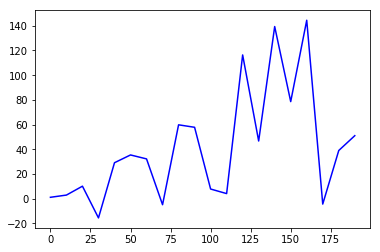

In [6]:
plt.plot(np.arange(int(no_episodes/batch_size))*batch_size, rf_reward, 'b')
plt.show()

In [9]:
## With second set of hyperparameters
no_episodes = 400
episode_len = 50  
batch_size = 20
alpha = 0.1

### these results are shown for easy level
rf_pfunc2, rf_reward2 = REINFORCE_learning(no_episodes, episode_len,batch_size, alpha)

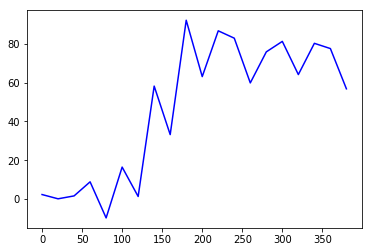

In [22]:
plt.plot(np.arange(int(no_episodes/batch_size))*batch_size, rf_reward2, 'b')
plt.show()

In [18]:
### Visualizing the example trajectory based on rf_pfunc 
### Not the best policy, just a trained policy using reinforce algorithm
### hyperparameters are not fully tuned

init_state, cur_pos = env.reset()

## Chose the trained policy and episode len to try the policy on
trained_policy = rf_pfunc2
eps_len = 100

## Store the position and action taken
record_pos = []
record_action = []
for t in range(eps_len):
    record_pos.append(cur_pos)
    ### policy based action gradient
    pmf_smax = np.exp(trained_policy[cur_pos,:]) / np.sum(np.exp(trained_policy[cur_pos,:]), axis=0)
    #### Here, trained_policy is the trained policy
    a = np.random.choice(np.arange(trained_policy.shape[1]), 1, replace=False, p=pmf_smax)
    action =  int(a) 
    record_action.append(action)
    ### Environment is propagated based on action taken
    next_state, reward, done, info = env.step(action)
    next_pos = info['pos'] ## S'        
    cur_pos = next_pos
    env.render()
env.close()

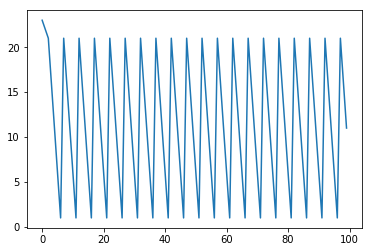

In [19]:
### Visualizing the trajectory
plt.plot(np.arange(eps_len), record_pos)
plt.show()